<h1> 2조 

## Library import

In [1]:
import warnings # 코드를 실행할 때, 밑에 빨간글씨처럼 뜨는 것들이 있었는데 그것들을 안뜨게 하는 것!
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from numpy import loadtxt

import matplotlib.pyplot as plt
import seaborn as sns
plt.rc('font', family='NanumGothic')

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, accuracy_score, roc_curve, auc, classification_report

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import xgboost as xgb

# dataset

In [2]:
data_df = pd.read_csv('titanic.csv')
data_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


# Age, Cabin, Embarked 의 Null값 확인

In [3]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


# Embarked 별 생존율의 차이 확인

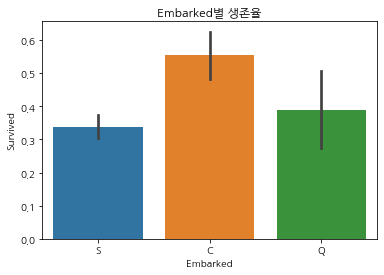

In [4]:
sns.barplot(x='Embarked', y='Survived', data=data_df)
plt.title('Embarked별 생존율')
plt.show()

# Pclass별 생존율 차이 확인

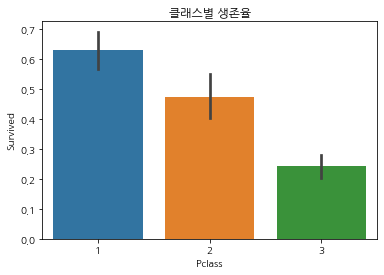

In [5]:
sns.barplot(x='Pclass', y='Survived', data=data_df)
plt.title('클래스별 생존율')
plt.show()

# 성별 생존율 차이 확인

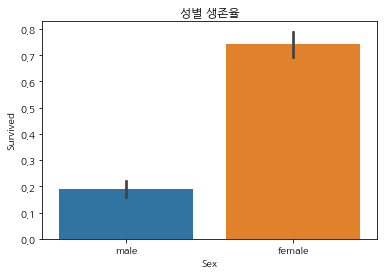

In [6]:
sns.barplot(x='Sex', y='Survived', data=data_df)
plt.title('성별 생존율')
plt.show()

# Age별 생존율 차이 확인

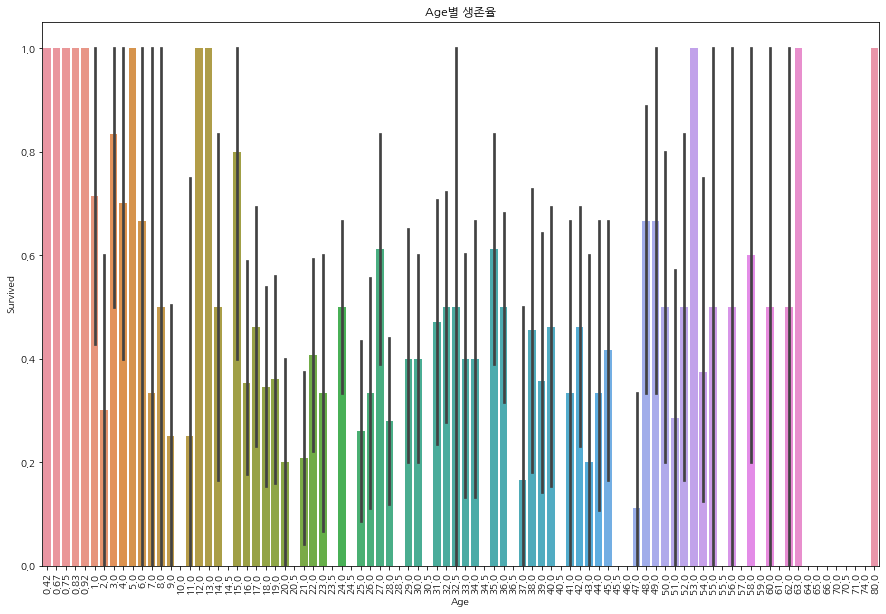

In [7]:
plt.figure(figsize=(15,10))
sns.barplot(x='Age', y='Survived', data=data_df)
plt.xticks(rotation=90)
plt.title('Age별 생존율')
plt.show()

# Target Feature 제외

In [8]:
del data_df['Survived']
x_data = data_df.copy()
x_data.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


# Cabin feature의 전처리 과정

1. Pclass 와 Embarked 별 생존율에 차이가 있다는 것을 확인
2. Pclass, Embarked 별 fare의 차이가 있는지 확인
3. Pclass 와 Embarked 와 fare의 차이는 타이타닉 호에서 객실 위치에 따른 차이라고 생각
4. 이는 탑승자들의 객실 위치인 Cabin도 중요한 feature일 것이라는 가설을 세움
<br>

5. 실제 타이타닉의 내부 구조를 찾아봄
6. **First Class 는 Carbin이 a~e, second 는 d~f , third는 d~g 까지** 가질 수 있음을 확인
7. 또한 Carbin 뒤에 숫자는 객실의 열방향 정보를 담고 있음을 가정
8. 즉, Carbin의 **앞 숫자는 x좌표, 뒤에 숫자는 y좌표**로 볼 수 있음
9. 이 중 a는 class 1에만 있는데 사진에서 보면 우측밖에 없는데, 번호는 낮은 숫자만 있는 것으로 보아 배에서 우측부터 번호가 시작함을 예상
<br>

10. y좌표 정보를 얻기 전 cabin의 결측치를 채우기 위해 Ticket 과 Fare, Cabin의 관계를 찾아봄
11. Fare를 내림차순으로 정렬해보니 Fare가 같으면 Ticket 번호도 같다는 사실을 알고
12. 같을 경우 해당 Cabin이 null값이 아닐 경우 해당 값으로 알파벳을 채움
<br>

13. 또한 가격에 따라서는 Cabin 값이 규칙을 찾기 쉽지 않아서 Ticket으로 정렬해보니
14. 비슷한 티켓 구간에는 Cabin의 알파벳과 숫자들의 비슷한 패턴을 가짐을 확인
15. 따라서 미처 채우지 못한 null 값들은 Pclass 별 데이터프레임을 뽑고 Ticket 을 기준으로 정렬을 한뒤
16. ffill 과 bfill을 사용해 결측치를 채움
<br>

17. 그리고 Cabin의 알파벳 A~G 까지를 0~6으로 mapping 하여 X축 좌표로 나타냄
18. 이후 y축 구간을 총 4분할로 쪼개서 제일 우측을 1, 제일 왼쪽을 4로 보고 총 4가지 값을 갖는 새로운 파생변수 group을 만듬
<br>

19. 1등급의 객실 위치를 그림으로 보아 2~3 의 y축 좌표만을 가질 수 있다고 가정
20. 2~3등급 같은 경우에는 위치상 1, 4 의y축 좌표만을 가질 수 있다고 가정
21. 1등급보다 우측에 있는 위치들을 y가 1이라고 보고 이 또한 작은 숫자들이 해당 위치에 있을 것이라고 가정
22. 제일 왼쪽에 있는 객실들은 4의 좌표를 가지게 group의 값을 지정하였음

## Cabin 전처리과정

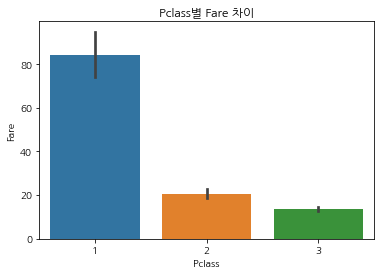

In [9]:
sns.barplot(x='Pclass', y='Fare', data=data_df)
plt.title('Pclass별 Fare 차이')
plt.show()

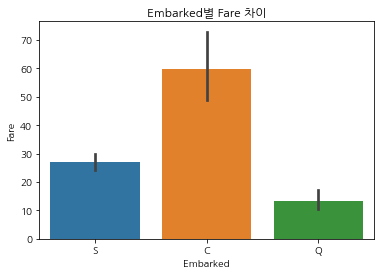

In [10]:
sns.barplot(x='Embarked', y='Fare', data=data_df)
plt.title('Embarked별 Fare 차이')
plt.show()

- Pclass, Embarked 별 Fare의 차이가 나는 이유는 승객의 객실위치에 따른 차이라고 가정함.
- 이에 Cabin 값을 살려보기로 결정

In [11]:
data_df['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

# 전체 Cabin값을 보아, 특징을 찾기 어려움.
# 따라서, Pclass 별 확인하기로 결정

In [12]:
# Feature의 select 조건(filtering)을 만들어 주는 부분
pc1 = x_data['Pclass'] == 1
pc2 = x_data['Pclass'] == 2
pc3 = x_data['Pclass'] ==3
e_s = x_data['Embarked'] =='S'
e_c = x_data['Embarked'] == 'C'
e_q = x_data['Embarked'] == 'Q'

# 두가지 조건를 동시에 충족하는 데이터를 필터링하여 새로운 변수에 저장
df_1_s = x_data[pc1 & e_s]
df_1_c = x_data[pc1 & e_c]
df_1_q = x_data[pc1 & e_q]

df_2_s = x_data[pc2 & e_s]
df_2_c = x_data[pc2 & e_c]
df_2_q = x_data[pc2 & e_q]

df_3_s = x_data[pc3 & e_s]
df_3_c = x_data[pc3 & e_c]
df_3_q = x_data[pc3 & e_q]

In [13]:
cabin_pc1 = x_data[pc1]['Cabin'].unique()
cabin_pc2 = x_data[pc2]['Cabin'].unique()
cabin_pc3 = x_data[pc3]['Cabin'].unique()

# Pclass별 Cabin 값

In [14]:
cabin_pc1

array(['C85', 'C123', 'E46', 'C103', 'A6', 'C23 C25 C27', nan, 'B78',
       'D33', 'B30', 'C52', 'B28', 'C83', 'E31', 'A5', 'D10 D12', 'D26',
       'C110', 'B58 B60', 'D47', 'B86', 'C2', 'E33', 'B19', 'A7', 'C49',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'C22 C26', 'C106', 'C65', 'E36', 'C54', 'B57 B59 B63 B66',
       'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40', 'T', 'C128',
       'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E44', 'A34', 'C104',
       'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14', 'B37', 'C30',
       'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38', 'B39', 'B22',
       'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68', 'B41', 'A20',
       'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48', 'E58', 'C126',
       'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'C62 C64', 'E24', 'C90',
       'C45', 'E8', 'B101', 'D45', 'C46', 'D30', 'D11', 'B3', 'D6',
       'B8

In [15]:
cabin_pc1 = np.delete(cabin_pc1, 6) # nan값 제외

for i in range(len(cabin_pc1)):
    if cabin_pc1[i][0] == 'A':
        print(cabin_pc1[i])

A6
A5
A7
A32
A31
A19
A34
A14
A16
A10
A20
A23
A26
A36
A24


: 위 A로 시작하는 Cabin 값들을 통해 class1 에서만 A가 존재함을 확인, 뒤의 숫자는 40 이하의 숫자만을 가지고 있음을 확인

In [16]:
for i in range(len(cabin_pc1)):
    if cabin_pc1[i][0] == 'B':
        print(cabin_pc1[i])

B78
B30
B28
B58 B60
B86
B19
B4
B80
B77
B94
B49
B57 B59 B63 B66
B18
B35
B96 B98
B37
B79
B73
B38
B39
B22
B41
B50
B71
B51 B53 B55
B5
B20
B101
B3
B82 B84
B102
B69
B42


In [17]:
for i in range(len(cabin_pc1)):
    if cabin_pc1[i][0] == 'C':
        print(cabin_pc1[i])

C85
C123
C103
C23 C25 C27
C52
C83
C110
C2
C49
C93
C78
C87
C125
C99
C118
C22 C26
C106
C65
C54
C7
C32
C124
C91
C128
C82
C104
C111
C92
C30
C95
C86
C70
C101
C68
C126
C62 C64
C90
C45
C46
C47
C50
C148


In [18]:
for i in range(len(cabin_pc1)):
    if cabin_pc1[i][0] == 'D':
        print(cabin_pc1[i])

D33
D10 D12
D26
D47
D36
D15
D35
D7
D37
D21
D20
D46
D19
D50
D9
D48
D49
D45
D30
D11
D6
D17
D28


In [19]:
for i in range(len(pc11)):
    if pc11[i][0] == 'E':
        print(pc11[i])

NameError: name 'pc11' is not defined

In [20]:
cabin_pc2

array([nan, 'D56', 'F33', 'E101', 'F2', 'F4', 'D', 'E77'], dtype=object)

In [21]:
cabin_pc3

array([nan, 'G6', 'F G73', 'F E69', 'E10', 'F G63', 'E121', 'F38'],
      dtype=object)

- Cabin값의 알파벳과 숫자의 의미가 무엇일지 추측하기 위해 타이타닉의 내부 구조를 정보를 찾음

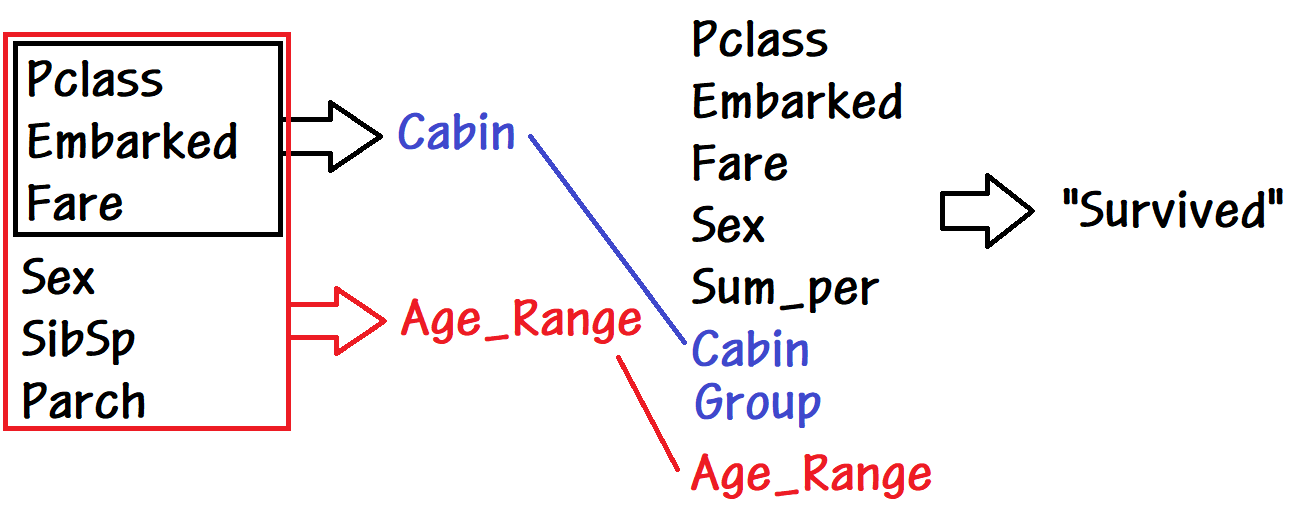

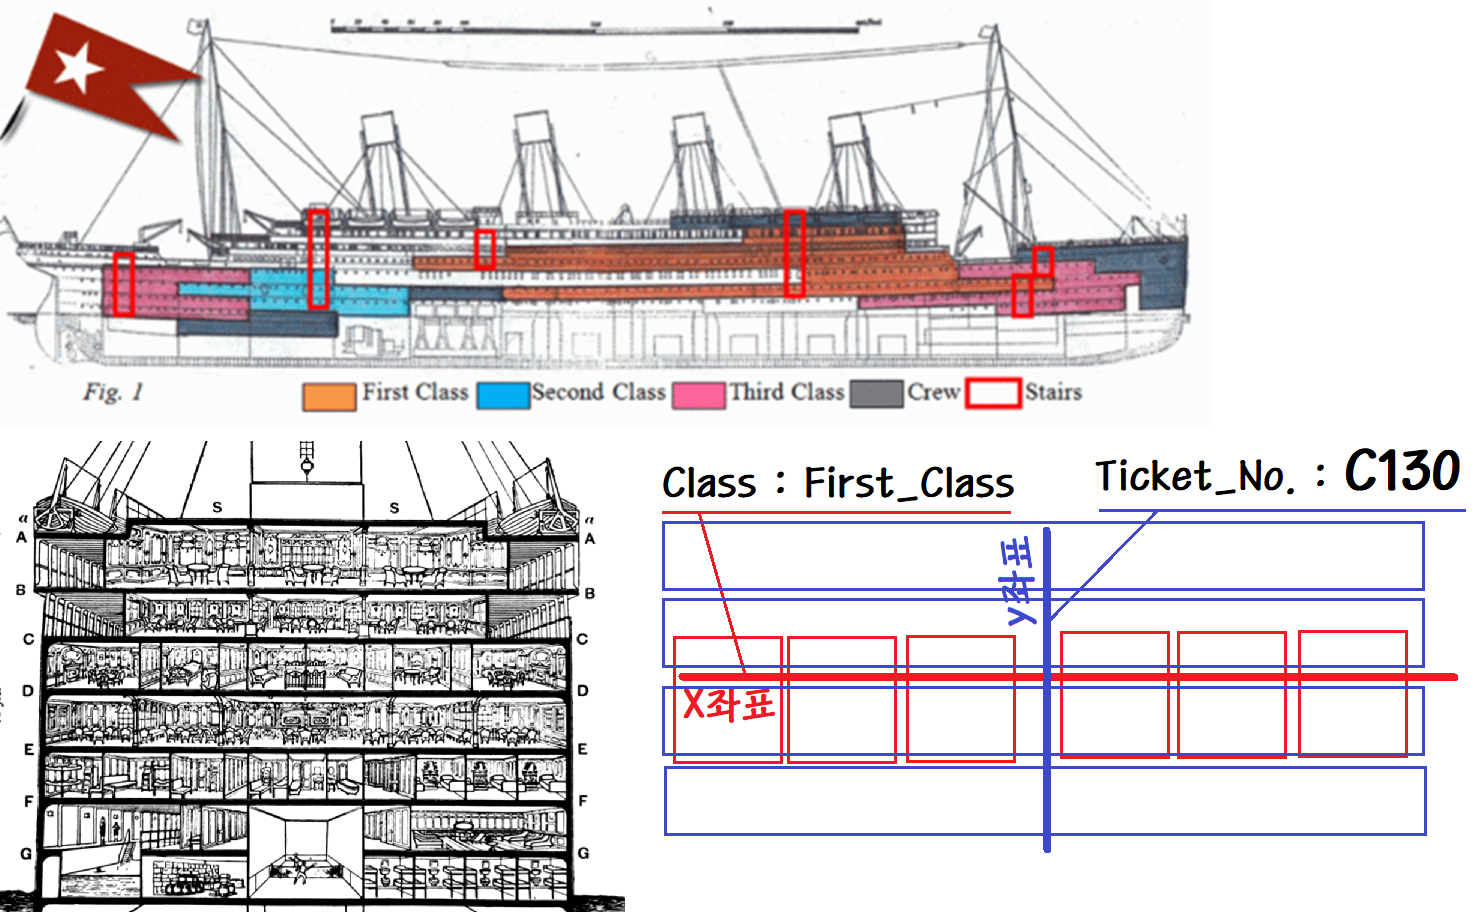

- 위의 두 사진을 통해 알파벳은 층의 위치( Y좌표 ), 뒤에 숫자는 방의 위치( X좌표 ) 로 볼 수 있다고 생각함.

- 따라서 Cabin을 공간좌표로 나눌 수 있음으로 보고 결측치가 많지만, 해당 feature를 살리기로 결정.

In [22]:
# Fare를 기준으로 내림차순 정렬을 해보았더니, 요금이 같으면 Ticket 이름도 같고, Cabin의 값도 같으며
# Ticket이 비슷한 이름을 가질경우, 알파벳과 숫자의 차이가 거의 비슷함을 알 수 있음.

x_data[pc1].sort_values('Fare', ascending=False)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
258,259,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C
737,738,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C
679,680,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C
88,89,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.0000,C23 C25 C27,S
27,28,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.0000,C23 C25 C27,S
...,...,...,...,...,...,...,...,...,...,...,...
815,816,1,"Fry, Mr. Richard",male,NaN,0,0,112058,0.0000,B102,S
806,807,1,"Andrews, Mr. Thomas Jr",male,39.0,0,0,112050,0.0000,A36,S
633,634,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0000,NaN,S
822,823,1,"Reuchlin, Jonkheer. John George",male,38.0,0,0,19972,0.0000,NaN,S


In [23]:
# 약간의 오차는 존재하지만 , 대체로 티켓범위가 비슷할수록 Cabin의 정보 또한 비슷함을 볼 수 있음.
x_data[pc1].sort_values('Ticket', ascending=True)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
257,258,1,"Cherry, Miss. Gladys",female,30.0,0,0,110152,86.500,B77,S
504,505,1,"Maioni, Miss. Roberta",female,16.0,0,0,110152,86.500,B79,S
759,760,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,33.0,0,0,110152,86.500,B77,S
262,263,1,"Taussig, Mr. Emil",male,52.0,1,1,110413,79.650,E67,S
558,559,1,"Taussig, Mrs. Emil (Tillie Mandelbaum)",female,39.0,1,1,110413,79.650,E67,S
...,...,...,...,...,...,...,...,...,...,...,...
537,538,1,"LeRoy, Miss. Bertha",female,30.0,0,0,PC 17761,106.425,NaN,C
544,545,1,"Douglas, Mr. Walter Donald",male,50.0,1,0,PC 17761,106.425,C86,C
92,93,1,"Chaffee, Mr. Herbert Fuller",male,46.0,1,0,W.E.P. 5734,61.175,E31,S
745,746,1,"Crosby, Capt. Edward Gifford",male,70.0,1,1,WE/P 5735,71.000,B22,S


In [24]:
# 따라서, 우선 Fare를 기준으로 내림차순 정렬을 시행 
c1 = x_data[pc1].sort_values('Fare',ascending=False)

# 이중for문을 통해 i는 cabin의 값이 null값을 찾는 것을 목적으로 반복문을 돌고,
# j는 i가 null값일 때, 해당 i의 티켓과 이름이 같으면서 null이 아닌 값을 찾은 후
# 해당 Cabin의 값을 i의 값에 채워주는 방식으로 진행 됨

for i in range(len(c1)):
    if (c1['Cabin'].iloc[i] is np.nan): # 데이터의 row들을 중간중간 drop 시켜서 사용하였기에, index가 맞지않아 .iloc[i] 를 통해 index를 접근함
        for j in range(len(c1)):
            if (c1['Ticket'].iloc[i] == c1['Ticket'].iloc[j]) and (c1['Cabin'].iloc[j] is not np.nan):
                c1['Cabin'].iloc[i] = c1['Cabin'].iloc[j][0] + c1['Cabin'].iloc[j][1] 
                # c1['Cabin'].iloc[j][0] -> Y축 정보를 담기 위해 가져오는 것
                # c1['Cabin'].iloc[j][1] -> X축 정보를 담기 위해 가져오는 것

# 위에 과정에서 1차로 null값을 채운 후 나머지 null값들을 채우기 위해 Ticket을 기준으로 정렬
c1 = c1.sort_values('Ticket',ascending=True)

# Ticket이 비슷할 때, cabin의 값이 비슷한 경우가 많고 달리 다른 방식으로 채우기엔 정보가 너무 부족하다고 판단,
# 정렬 후에 데이터셋을 기준으로 ffill를 사용하여 결측치를 채우기로 결정
c1['Cabin'] = c1['Cabin'].fillna(method='ffill') # 열 기준으로 보았을 때 앞선 행의 데이터로 아래 null을 fill

# ffill로 진행할 경우, 6번인덱스가 null값일 때, 5번 인덱스 값으로 채워지는데, 이는 맨 앞에 인덱스가 null값일 경우
# 맨 앞은 null값이 채워지지가 않음.
# 따라서, 맨 앞에 존재하는 null값을 채우기위해 다소 정확하진 않지만 bfill을 사용하여 잔여 null을 채움
c1['Cabin'] = c1['Cabin'].fillna(method='bfill') # 열 기준으로 보았을 때 아래 행의 데이터로 위 null을 fill

# 위와 같은 과정을 Pclass별 따로 진행하여 총 3번을 진행함.

In [25]:
c2 = x_data[pc2].sort_values('Fare',ascending=False)

for i in range(len(c2)):
    if (c2['Cabin'].iloc[i] is np.nan):
        for j in range(len(c2)):
            if (c2['Ticket'].iloc[i] == c2['Ticket'].iloc[j] and c2['Cabin'].iloc[j] is not np.nan):
                c2['Cabin'].iloc[i] = c2['Cabin'].iloc[j][0] + c2['Cabin'].iloc[j][1]
                
c2 = c2.sort_values('Ticket',ascending=True)

c2['Cabin'] = c2['Cabin'].fillna(method='ffill')
c2['Cabin'] = c2['Cabin'].fillna(method='bfill')

In [26]:
c3 = x_data[pc3].sort_values('Fare',ascending=False)

for i in range(len(c3)):
    if (c3['Cabin'].iloc[i] is np.nan):
        for j in range(len(c3)):
            if (c3['Ticket'].iloc[i] == c3['Ticket'].iloc[j] and c3['Cabin'].iloc[j] is not np.nan):
                c3['Cabin'].iloc[i] = c3['Cabin'].iloc[j][0] + c3['Cabin'].iloc[j][1]
                
c3 = c3.sort_values('Ticket',ascending=True)

c3['Cabin'] = c3['Cabin'].fillna(method='ffill')
c3['Cabin'] = c3['Cabin'].fillna(method='bfill')

In [27]:
# Pclass별 filling을 진행해서 얻은 3개의 데이터프레임을 하나의 c123으로 합치는 부분

df_cabin_filled = pd.concat([c1, c2, c3])
df_cabin_filled = df_cabin_filled.sort_values('Ticket',ascending=True)
df_cabin_filled.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin            0
Embarked         2
dtype: int64

In [28]:
# 결측치를 채운 데이터셋으로 새로운 파생변수 group을 만들기 위해 다시 Pclass별로 나눔.

c1_c = df_cabin_filled[ df_cabin_filled['Pclass'] == 1 ]
c2_c = df_cabin_filled[ df_cabin_filled['Pclass'] == 2 ]
c3_c = df_cabin_filled[ df_cabin_filled['Pclass'] == 3 ]

In [29]:
group = [] 

# X축 정보를 담는 새로운 feature group을 채우는 부분
# A값이 40이하의 숫자들만 존재하기에 방번호는 타이타닉호의 선수를 기준으로 시작한다고 가정
# 또한 사진 내, A의 위치상 x좌표가 2의 값을 갖는다고 보고 A위치를 기준으로 2로 설정
# 이보다 우측에 있을 경우 1, 좌측에 있을 경우 , 3 과 4의 값을 갖는다고 설정함.

for i in range(len(c1_c)):
    
    if c1_c['Cabin'].iloc[i][0] =='A':
        group.append(2)
        c1_c['Cabin'].iloc[i] =  c1_c['Cabin'].iloc[i][0] 
    elif (c1_c['Cabin'].iloc[i][0]== 'B') and (int(c1_c['Cabin'].iloc[i][1]) <4):
        group.append(2)
        c1_c['Cabin'].iloc[i] =  c1_c['Cabin'].iloc[i][0] 
    elif (c1_c['Cabin'].iloc[i][0] == 'B') and (int(c1_c['Cabin'].iloc[i][1]) >= 4):
        group.append(3)
        c1_c['Cabin'].iloc[i] =  c1_c['Cabin'].iloc[i][0] 
    elif (c1_c['Cabin'].iloc[i][0] == 'C') and (int(c1_c['Cabin'].iloc[i][1]) <4):
        group.append(2)
        c1_c['Cabin'].iloc[i] =  c1_c['Cabin'].iloc[i][0] 
    elif (c1_c['Cabin'].iloc[i][0] == 'C') and (int(c1_c['Cabin'].iloc[i][1]) >=4) :
        group.append(3)
        c1_c['Cabin'].iloc[i] =  c1_c['Cabin'].iloc[i][0] 
    elif (c1_c['Cabin'].iloc[i][0] == 'D'):
        group.append(2)
        c1_c['Cabin'].iloc[i] =  c1_c['Cabin'].iloc[i][0] 
    elif (c1_c['Cabin'].iloc[i][0] == 'E') and (int(c1_c['Cabin'].iloc[i][1]) <4):
        group.append(2)
        c1_c['Cabin'].iloc[i] =  c1_c['Cabin'].iloc[i][0] 
    elif (c1_c['Cabin'].iloc[i][0] == 'E') and (int(c1_c['Cabin'].iloc[i][1]) >=4):
        group.append(3)
        c1_c['Cabin'].iloc[i] =  c1_c['Cabin'].iloc[i][0] 
    else:
        group.append(3)
        c1_c['Cabin'].iloc[i] =  c1_c['Cabin'].iloc[i][0] 
        
c1_c['group'] = group
c1_c.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,group
759,760,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,33.0,0,0,110152,86.5,B,S,3
504,505,1,"Maioni, Miss. Roberta",female,16.0,0,0,110152,86.5,B,S,3
257,258,1,"Cherry, Miss. Gladys",female,30.0,0,0,110152,86.5,B,S,3


In [30]:
group = []

# 마찬가지로 class2 같은 경우, 그림상 X좌표를 3 과 4 의 값만을 가질 수 있다고 보고, 다음과 같이 설정함. 
for i in range(len(c2_c)):
    
    if c2_c['Cabin'].iloc[i][0] =='D':
        group.append(3)
        c2_c['Cabin'].iloc[i] =  c2_c['Cabin'].iloc[i][0] 
    elif (c2_c['Cabin'].iloc[i][0]== 'E') and (int(c2_c['Cabin'].iloc[i][1]) <4):
        group.append(3)
        c2_c['Cabin'].iloc[i] =  c2_c['Cabin'].iloc[i][0] 
    elif (c2_c['Cabin'].iloc[i][0] == 'E') and (int(c2_c['Cabin'].iloc[i][1]) >= 4):
        group.append(4)
        c2_c['Cabin'].iloc[i] =  c2_c['Cabin'].iloc[i][0] 
    elif (c2_c['Cabin'].iloc[i][0] == 'F'):
        group.append(3)
        c2_c['Cabin'].iloc[i] =  c2_c['Cabin'].iloc[i][0] 
    else:
        group.append(3)
        c2_c['Cabin'].iloc[i] =  c2_c['Cabin'].iloc[i][0] 
        
c2_c['group'] = group
c2_c.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,group
117,118,2,"Turpin, Mr. William John Robert",male,29.0,1,0,11668,21.0,E,S,3
41,42,2,"Turpin, Mrs. William John Robert (Dorothy Ann ...",female,27.0,1,0,11668,21.0,E,S,3
722,723,2,"Gillespie, Mr. William Henry",male,34.0,0,0,12233,13.0,E,S,3


In [31]:
# class3 같은 경우, 결측치가 아닌 값에서 Cabin의 방 번호가 여러개 혹은 알파벳에 공백까지 포함된 이상치가 존재하였기에,
# 공백이 있을 경우 < 3 의 조건을 사용하여 새로 값을 지정 ex. (F )
# 방 번호가 여러 개 일 경우, == 5 조건을 사용하여 새로 값을 지정 ex. (F G20)

for i in range(len(c3_c)):
    
    if len(c3_c['Cabin'].iloc[i]) <3:
        c3_c['Cabin'].iloc[i] = c3_c['Cabin'].iloc[i][0] + '1'
    if len(c3_c['Cabin'].iloc[i]) ==5:
        c3_c['Cabin'].iloc[i] = c3_c['Cabin'].iloc[i][0] + c3_c['Cabin'].iloc[i][3]

In [32]:
group=[]

# class3의 경우, 그림상 X좌표가 1 과 4 의 값만을 가질 수 있으므로 다음과 같이 설정함. 
for i in range(len(c3_c)):
        
    if (c3_c['Cabin'].iloc[i][0]== 'E') and (int(c3_c['Cabin'].iloc[i][1]) <4):
        group.append(1)
        c3_c['Cabin'].iloc[i] =  c3_c['Cabin'].iloc[i][0] 
    elif (c3_c['Cabin'].iloc[i][0] == 'E') and (int(c3_c['Cabin'].iloc[i][1]) >= 4):
        group.append(4)
        c3_c['Cabin'].iloc[i] =  c3_c['Cabin'].iloc[i][0] 
    elif (c3_c['Cabin'].iloc[i][0] == 'F'):
        group.append(1)
        c3_c['Cabin'].iloc[i] =  c3_c['Cabin'].iloc[i][0] 
    elif (c3_c['Cabin'].iloc[i][0] == 'G') and (int(c3_c['Cabin'].iloc[i][1]) < 4):
        group.append(1)
        c3_c['Cabin'].iloc[i] =  c3_c['Cabin'].iloc[i][0] 
    elif (c3_c['Cabin'].iloc[i][0] == 'G') and (int(c3_c['Cabin'].iloc[i][1]) >= 4):
        group.append(4)
        c3_c['Cabin'].iloc[i] =  c3_c['Cabin'].iloc[i][0] 
    else:
        group.append(1)
        c3_c['Cabin'].iloc[i] =  c3_c['Cabin'].iloc[i][0] 
        
c3_c['group'] = group
c3_c.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,group
790,791,3,"Keane, Mr. Andrew ""Andy""",male,NaN,0,0,12460,7.75,F,Q,1
47,48,3,"O'Driscoll, Miss. Bridget",female,NaN,0,0,14311,7.75,F,Q,1
573,574,3,"Kelly, Miss. Mary",female,NaN,0,0,14312,7.75,F,Q,1


In [33]:
# 최종적으로 X좌표의 정보를 담는 group feature가 추가되고, Cabin의 null값이 정리된 데이터셋들을 concat해주는 부분
df_cabin_group = pd.concat([c1_c, c2_c, c3_c])
# 새로 합치면서 엉망이된 index들의 순서를 정렬시켜줌
df_cabin_group = df_cabin_group.sort_index()
df_cabin_group.head(3)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,group
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,E,S,1
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,3
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,E,S,1


In [34]:
check = [] # 빈 리스트 생성

# Cabin의 값이, A~G가 아닌 값의 존재를 확인, 해당 index를 뽑아냄
for i in range(len(df_cabin_group)):
    if df_cabin_group['Cabin'].iloc[i] =='T':
        check.append(i)
    
check

[339]

In [35]:
df_cabin_group.iloc[339]

PassengerId                             340
Pclass                                    1
Name           Blackwell, Mr. Stephen Weart
Sex                                    male
Age                                    45.0
SibSp                                     0
Parch                                     0
Ticket                               113784
Fare                                   35.5
Cabin                                     T
Embarked                                  S
group                                     3
Name: 339, dtype: object

In [36]:
# T의 값이 무엇을 의미하는지 찾지 못하였지만, 해당 index의 Ticket값으로 보아 C로 대체할 수 있음을 확인하고 값을 대체함.

df_cabin_group['Cabin'].iloc[339] = 'C'

In [37]:
# cabin의 값을 numeric 타입으로 인코딩 해주는 부분.

cabin_mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E':4, 'F' :5, 'G':6}
df_cabin_group['Cabin'] = df_cabin_group['Cabin'].map(cabin_mapping)

In [38]:
# age값을 머신러닝을 통해 예측된 값으로 저장된 csv파일에서 불러옴,  
# '1. modeling for prediction on Age column (XGBoost).ipynb' 참고 

df_withage = pd.read_csv('titanic_age_filled.csv') 

In [39]:
# numeric 타입으로 인코딩된 값으로 대체해주는 부분
df_cabin_group['Age'] = df_withage['Age_range']
df_cabin_group['Sex'] = df_withage['Sex_num']
df_cabin_group['Sum_Family'] = df_withage['Sum_Family']

In [40]:
# 최종 train을 위한 feature들을 선택해주는 부분
main_x = df_cabin_group[['Pclass', 'Sex', 'Age', 'Cabin', 'group', 'Sum_Family', 'Fare']]

In [41]:
# 최종 target을 선택해주는 부분
main_y = df_withage['Survived']

-------------

# 이로써, Cabin은 Y좌표 정보를, group은 X좌표 정보를 담고 있음
# X : 1~ 4 ,  Y : 0~6 의 범위를 갖음

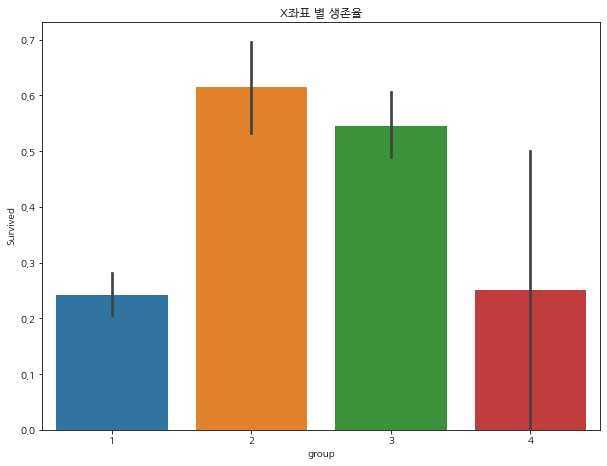

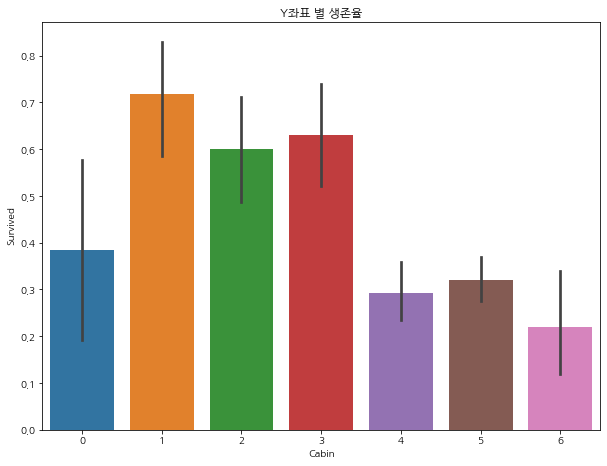

In [42]:
# 새로 만든 group과 Cabin의 값들이 실제 생존율의 차이가 있는지 확인하기 위해 그래프를 그려봄

main_x['Survived'] = df_withage['Survived']

plt.rcParams['figure.figsize'] = [10, 7.5]
sns.barplot(x='group', y='Survived', data=main_x)
plt.title('X좌표 별 생존율')
plt.show()
plt.rcParams['figure.figsize'] = [10, 7.5]
sns.barplot(x='Cabin', y='Survived', data=main_x)
plt.title('Y좌표 별 생존율')
plt.show()

----------

#  feature들 간 스케일 불균형 정규화

In [43]:
scaler = StandardScaler()

main_x = df_cabin_group[['Pclass', 'Sex', 'Age', 'Cabin', 'group', 'Sum_Family', 'Fare']]
scaler.fit(main_x)
main_x_scaled = scaler.transform(main_x)

# RandomForest

In [44]:
X = main_x_scaled
y = main_y

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=4)

model_rf = RandomForestClassifier(n_estimators=1000).fit(X_train, y_train)

# 예측
pred_rf = model_rf.predict(X_test)

# 정확도 확인
score_test_RF = accuracy_score(y_test, pred_rf)
print('정확도 :', score_test_RF)

정확도 : 0.8395522388059702


----------

# XGboost

[15:12:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
정확도 : 0.8470149253731343


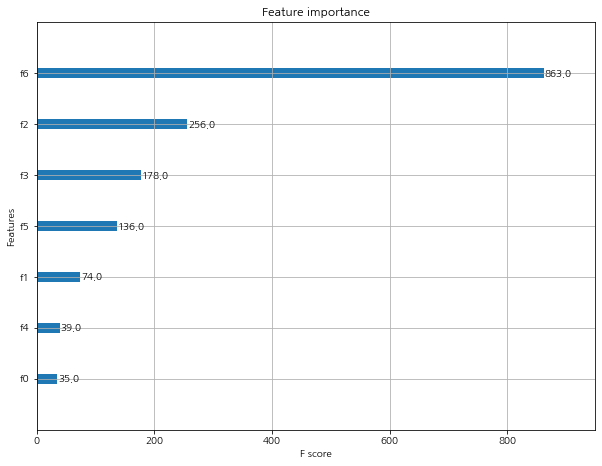

In [45]:
model_XG = xgb.XGBClassifier()
model_XG.fit(X_train, y_train)

pred_xg = model_XG.predict(X_test)

score_test_XG = model_XG.score(X_test, y_test)
print('정확도 :', score_test_XG)

xgb.plot_importance(model_XG)
plt.show()

------

# Gradient boosting Classifier

In [46]:
model_gb = GradientBoostingClassifier(random_state=0) # 기본값: max_depth=3, learning_rate=0.1

model_gb.fit(X_train, y_train)

score_train_GB = model_gb.score(X_train, y_train) # train set 정확도
print('{:.3f}'.format(score_train_GB))

pred_gb = model_gb.predict(X_test)
score_test_GB = model_gb.score(X_test, y_test) # 일반화 정확도

print('{:.3f}'.format(score_test_GB))

0.884
0.869


# GirdSearchCV

In [47]:
gb_param_grid={
'n_estimators':[100,200],
'max_depth' : [3,6,8,10,12],
'min_samples_leaf' : [1,2,3,5,10],
'learning_rate' : [0.05,0.1,0.2]
}

gb_grid = GridSearchCV(model_gb, param_grid = gb_param_grid, scoring="accuracy", n_jobs=1, verbose=1)
gb_grid_fitted = gb_grid.fit(X_train,y_train)

model = gb_grid_fitted.best_estimator_
pred_grid = model.predict(X_test)
acc_grid = accuracy_score(y_test, pred_grid)

print('{:.3f}'.format(acc_grid))

Fitting 5 folds for each of 150 candidates, totalling 750 fits
0.854


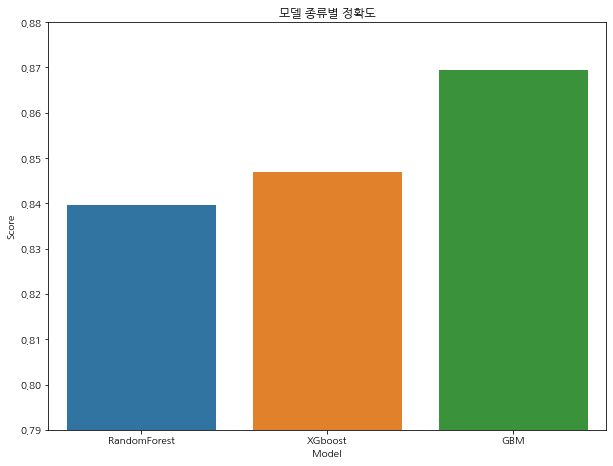

In [48]:
score_dict = {"Score" : [score_test_RF, score_test_XG, score_test_GB], "Model" : ['RandomForest', 'XGboost', 'GBM']}

df_score = pd.DataFrame(score_dict)
df_score

plt.rcParams['figure.figsize'] = [10, 7.5]
sns.barplot(x='Model', y='Score', data=df_score)
plt.title('모델 종류별 정확도')
plt.ylim((0.79,0.88))
plt.show()

# confusion matrix

In [49]:
print('RandomForest')
print(classification_report(y_test, pred_rf, target_names=['Unsurv', 'Surv']))
print('XGboost')
print(classification_report(y_test, pred_xg, target_names=['Unsurv', 'Surv']))
print('GBM')
print(classification_report(y_test, pred_gb, target_names=['Unsurv', 'Surv']))

RandomForest
              precision    recall  f1-score   support

      Unsurv       0.88      0.88      0.88       178
        Surv       0.76      0.76      0.76        90

    accuracy                           0.84       268
   macro avg       0.82      0.82      0.82       268
weighted avg       0.84      0.84      0.84       268

XGboost
              precision    recall  f1-score   support

      Unsurv       0.88      0.89      0.89       178
        Surv       0.78      0.77      0.77        90

    accuracy                           0.85       268
   macro avg       0.83      0.83      0.83       268
weighted avg       0.85      0.85      0.85       268

GBM
              precision    recall  f1-score   support

      Unsurv       0.88      0.93      0.90       178
        Surv       0.84      0.76      0.80        90

    accuracy                           0.87       268
   macro avg       0.86      0.84      0.85       268
weighted avg       0.87      0.87      0.87      

# ROC curve

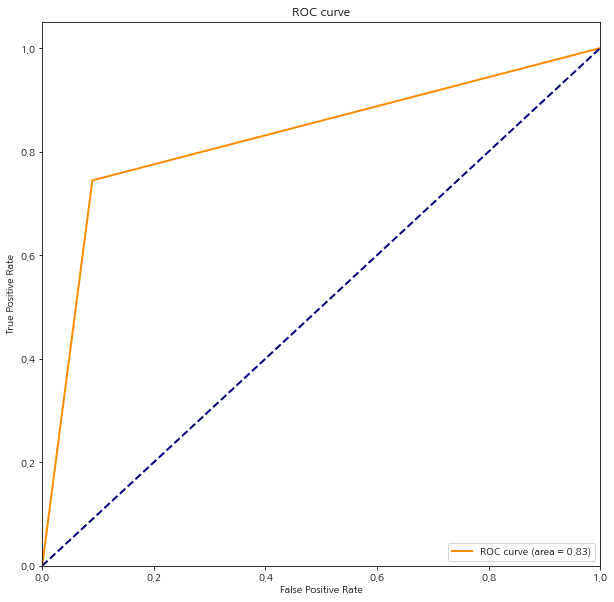

In [50]:
fpr, tpr, _ = roc_curve(y_true=y_test, y_score=pred_grid) 
roc_auc = auc(fpr, tpr) # AUC 면적의 값 (수치)

plt.figure(figsize=(10, 10))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title("ROC curve")
plt.show()